In [1]:
import pickle
import random
import math
import warnings
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from datetime import datetime
from datetime import timedelta
%matplotlib inline
# plt.matplotlib.rcParams.update({'font.size': 50})
warnings.filterwarnings('ignore')
plt.rcParams['figure.figsize'] = (12.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'   
plt.rcParams["patch.force_edgecolor"] = False
plt.rc('figure', titlesize=25)

In [13]:
PICKLE_PATH = '../augmented_datasets/pickles/hopkins_conf_gf0904_GDP_urban_weather.pkl'
OUTPUT_TREE_PATH = '../products/decision_tree/decision_tree_{0}.dot'

In [3]:
from sklearn.model_selection import KFold
from sklearn import tree, metrics

def train_test_split(X, n_splits=5):
    '''
    Splits rows into training indices and test indices.
    :param X: numpy array of training data, e.g.  np.array([[1, 2], [3, 4], [1, 2], [3, 4]]) - each sample has two features
    :return: Returns indices of rows for train and test for n_splits. e.g. n_splits=2: 
    train_folds = [[0,2,3], [1,2,3]] test_folds = [[1], [0]] 
    '''

    kf = KFold(n_splits=n_splits, random_state=2346, shuffle=True)
    kf.get_n_splits(X)
    
    train_folds, test_folds = [], []
    
    for train_index, test_index in kf.split(X):
        train_folds.append(train_index)
        test_folds.append(test_index)
    
    return train_folds, test_folds


def decision_tree_train(X_train, y_train):
    dt = tree.DecisionTreeRegressor()
    trained_model = dt.fit(X_train, y_train)
    return trained_model


def linear_regression_train(X_train, y_train):
    regr = sklearn.linear_model.LinearRegression()
    trained_model = regr.fit(X_train, y_train)
    return trained_model

###### Prepare data

In [4]:
hopkins_confirmed = pd.read_pickle(PICKLE_PATH)

Some of the 'first_7' rows are nans (for samples where n>20 but 7 days have not passed)

Some of the Province_State are nans (Not all countries have provinces)

In [5]:
hopkins_confirmed = pd.read_pickle(PICKLE_PATH)
nan_countries = []
nan_first_7 = []
for column in hopkins_confirmed.columns:
    any_nan = hopkins_confirmed[column].loc[:, 'data'].isna().any()
    nulls = hopkins_confirmed[column].loc[:, 'data'].isna().tolist()
    if any_nan:
        size = len([nul for nul in nulls if nul])
        print('{0}: {1}, {2}'.format(column, any_nan, size))
        for i in range(len(nulls)):
            if column == 'Country_Region':
                nc = hopkins_confirmed['Country_Region'].index[i][0]
                nan_countries.append(nc)
            if column == 'first_7':
                nc = hopkins_confirmed['first_7'].index[i][0]
                nan_first_7.append(nc)
# hopkins_confirmed.drop(nan_first_7, level=0, inplace=True) # This was removed because it was buggy. the dropna is better and robust
hopkins_confirmed['Province_State'] = hopkins_confirmed['Province_State'].fillna('')
hopkins_confirmed.dropna(inplace=True)

Province_State: True, 137
first_7: True, 7


In [6]:
hopkins_confirmed.describe()

,GDP,Urbanization,avg_m_tmp,avg_m_RH,avg_m_precip,avg_m_wind,Max_Cases,first_7,avg_interval_tmp,avg_interval_RH,...,3/29/2020,3/30/2020,3/31/2020,4/1/2020,4/2/2020,4/3/2020,4/4/2020,4/5/2020,4/6/2020,4/7/2020
count,1063.000000,1063.000000,1063.000000,1063.000000,1063.000000,1063.000000,1063.000000,1063.000000,1063.000000,1063.000000,...,1063.000000,1063.000000,1063.000000,1063.000000,1063.000000,1063.000000,1063.000000,1063.000000,1063.000000,1063.000000
mean,52090.890353,74.345655,9.437621,70.902462,1.787219,11.821452,1697.803387,2.956743,12.756306,70.007057,...,801.333020,877.954845,973.146754,1065.435560,1168.716839,1275.482596,1402.503293,1498.430856,1593.976482,1697.771402
std,21121.453292,14.627599,7.605476,9.057977,1.680550,3.679917,14993.072453,1.775053,7.358585,10.131658,...,6814.353811,7483.586652,8312.659775,9136.641046,10074.017100,11074.739093,12233.869566,13114.647699,14028.638112,14993.075916
min,396.000000,14.338000,-16.824675,11.831169,0.000000,3.007246,20.000000,0.000000,-9.926087,8.444444,...,0.000000,0.000000,2.000000,2.000000,4.000000,4.000000,0.000000,0.000000,0.000000,17.000000
25%,46609.000000,66.300000,3.940260,66.883117,0.032987,9.331169,37.000000,1.707143,6.837778,66.533333,...,11.000000,13.000000,16.000000,18.000000,21.000000,23.500000,27.000000,30.500000,33.000000,37.000000
50%,55172.000000,75.100000,8.459740,72.558442,1.604928,11.415152,88.000000,2.666667,11.987500,71.666667,...,28.000000,33.000000,38.000000,44.000000,51.000000,58.000000,66.000000,73.000000,79.000000,88.000000
75%,61594.000000,86.200000,13.906494,76.493506,2.681688,14.015584,308.500000,4.000000,17.919048,76.281746,...,118.000000,135.000000,152.000000,173.500000,203.500000,222.000000,251.000000,265.500000,286.000000,308.500000
max,200277.000000,100.000000,32.323377,88.608696,7.818052,29.774026,396223.000000,11.000000,35.100000,94.000000,...,140909.000000,161837.000000,188172.000000,213372.000000,243616.000000,275586.000000,308850.000000,337072.000000,366667.000000,396223.000000


Discard outlier data

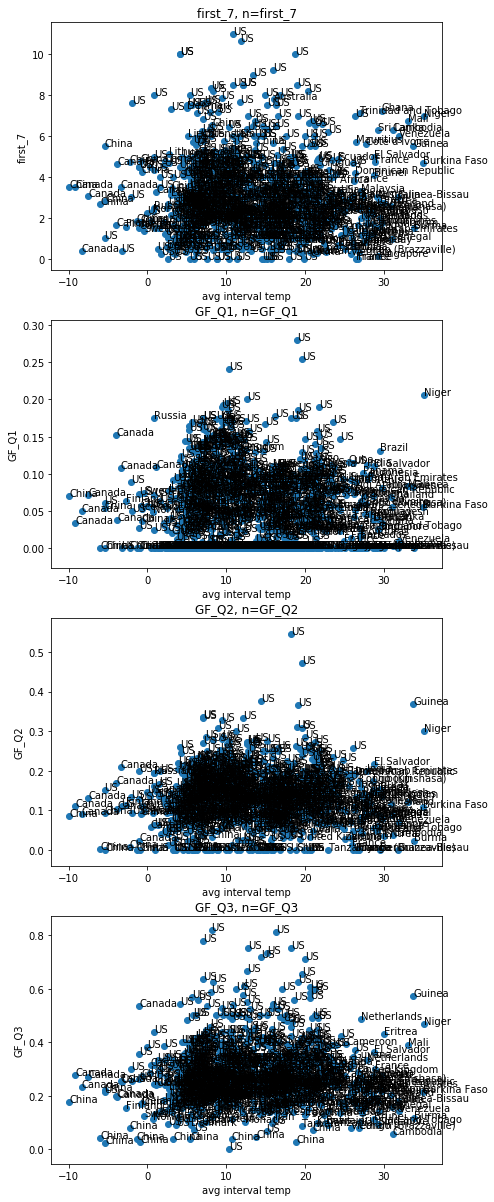

In [26]:
target_columns = ['first_7', 'GF_Q1', 'GF_Q2', 'GF_Q3']
avg_tmp = hopkins_confirmed[['Country_Region', 'avg_interval_tmp']].copy()
gf = hopkins_confirmed[target_columns].copy()

fig, axes = plt.subplots(4, 1, figsize=(7, 21))

for i in range(len(target_columns)):
    avg_int_tmp = avg_tmp['avg_interval_tmp'].values
    _ = axes[i].scatter(avg_int_tmp, gf[gf.columns[i]].values)
    n = len(avg_tmp['avg_interval_tmp'])
    _ = axes[i].set_xlabel('avg interval temp')
    _ = axes[i].set_ylabel(gf.columns[i])
    _ = axes[i].set_title('{0}, n={0}'.format(gf.columns[i], n))

    countries = hopkins_confirmed['Country_Region'].loc[:,'data'].values.tolist()
    for q, txt in enumerate(countries):
        _ = axes[i].annotate(txt, (avg_int_tmp[q], gf[gf.columns[i]].values[q]))


###### Regression and decision tree

###### Regression

In [48]:
# Desired data we wish to train-test on - needs to be a pandas data frame formatted like 'colds' or 'hots':
data = hopkins_confirmed
feature_cols = ['GDP', 'Urbanization', 'avg_interval_tmp', 'avg_interval_RH']
label_cols = ['first_7', 'GF_Q1', 'GF_Q2', 'GF_Q3']

model_fn = linear_regression_train

metric_fn = metrics.mean_squared_error

for label_col in label_cols:
    X, y = np.array(data[feature_cols]), np.array(data[[label_col]])
    # Split the data into train, test for n_splits train-test rounds
    train_folds, test_folds = train_test_split(X, n_splits=5)
    
    print('\nTraining on label {0}'.format(label_col))
    # Train-test the model for each of the n_splits:
    for train_test_round in range(len(train_folds)):
        train_index = train_folds[train_test_round]
        test_index = test_folds[train_test_round]
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        dt_trained = decision_tree_train(X_train, y_train)
        if model_fn == decision_tree_train: 
            tree.plot_tree(dt_trained, feature_names=feature_cols)
        # evaluate on test
        y_pred = dt_trained.predict(X_test)
        print('mean squared error run {0}: {1}'.format(train_test_round, metric_fn(y_test, y_pred)))
#         plt.scatter(X_test[2], y_test.T,  color='black')
#         plt.plot(X_test[2], y_pred.T, color='blue', linewidth=3)
#         plt.xticks(())
#         plt.yticks(())
#         plt.show()        


Training on label first_7
mean squared error run 0: 6.650518264977673
mean squared error run 1: 6.6423090283174515
mean squared error run 2: 5.850302024856821
mean squared error run 3: 5.6458307247829405
mean squared error run 4: 6.551227277722381

Training on label GF_Q1
mean squared error run 0: 0.003490184246625587
mean squared error run 1: 0.003807233310592723
mean squared error run 2: 0.0037422025638204227
mean squared error run 3: 0.0036269243727889153
mean squared error run 4: 0.0034640959139150937

Training on label GF_Q2
mean squared error run 0: 0.006498130410798122
mean squared error run 1: 0.007555239565727699
mean squared error run 2: 0.0069970566842723
mean squared error run 3: 0.006332430931603774
mean squared error run 4: 0.007077384357311321

Training on label GF_Q3
mean squared error run 0: 0.02184077176887715
mean squared error run 1: 0.018149488823356805
mean squared error run 2: 0.019214922195569247
mean squared error run 3: 0.020292159224646226
mean squared error

##### Decision tree

In [14]:
# Desired data we wish to train-test on - needs to be a pandas data frame formatted like 'colds' or 'hots':
data = hopkins_confirmed
feature_cols = ['GDP', 'Urbanization', 'avg_interval_tmp', 'avg_interval_RH']
label_cols = ['first_7', 'GF_Q1', 'GF_Q2', 'GF_Q3']

model_fn = decision_tree_train

metric_fn = metrics.mean_squared_error

for label_col in label_cols:
    X, y = np.array(data[feature_cols]), np.array(data[[label_col]])
    # Split the data into train, test for n_splits train-test rounds
    train_folds, test_folds = train_test_split(X, n_splits=5)
    
    print('\nTraining on label {0}'.format(label_col))
    # Train-test the model for each of the n_splits:
    for train_test_round in range(len(train_folds)):
        train_index = train_folds[train_test_round]
        test_index = test_folds[train_test_round]
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        dt_trained = decision_tree_train(X_train, y_train)
        if model_fn == decision_tree_train: 
            # tree.plot_tree(dt_trained, feature_names=feature_cols)
            suffix = label_col + '_run' + str(train_test_round)
            _ = tree.export_graphviz(dt_trained, OUTPUT_TREE_PATH.format(suffix)) # dot -Tpng tree.dot -o tree.png 
        # evaluate on test
        y_pred = dt_trained.predict(X_test)
        print('mean squared error run {0}: {1}'.format(train_test_round, metric_fn(y_test, y_pred)))


Training on label first_7
mean squared error run 0: 6.263621317557417
mean squared error run 1: 6.821639524476549
mean squared error run 2: 5.460119263300555
mean squared error run 3: 5.567859964776041
mean squared error run 4: 5.920763808814822

Training on label GF_Q1
mean squared error run 0: 0.003480609642752348
mean squared error run 1: 0.003917681007188967
mean squared error run 2: 0.0038058053572476535
mean squared error run 3: 0.004174623735996462
mean squared error run 4: 0.0034989594958726414

Training on label GF_Q2
mean squared error run 0: 0.006312218295187794
mean squared error run 1: 0.0066428558685446
mean squared error run 2: 0.00658561123826291
mean squared error run 3: 0.006058890775353774
mean squared error run 4: 0.006612294652122642

Training on label GF_Q3
mean squared error run 0: 0.022211901249510956
mean squared error run 1: 0.018814889920774645
mean squared error run 2: 0.01931499888277582
mean squared error run 3: 0.019765345106132072
mean squared error run